In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import time

In [0]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy import vstack
from numpy import savez_compressed

from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import Input

In [0]:
from os import listdir

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


In [0]:
# load all sketches in the sketch_directory into memory
def load_sketches(path, size=(256,256)):
    skt_list = list()
    # enumerate filenames in sketch directory
    for filename in sorted(listdir(path)):
        # load and resize the image
        skt_pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        skt_pixels = img_to_array(skt_pixels)
        skt_list.append(skt_pixels)
    return asarray(skt_list)
    

In [0]:
# load all real images in the real_images directory into memory
def load_realimg(path, size=(256,256)):
    real_list = list()
    # enumerate filenames in real image directory, assume all are images
    for filename in sorted(listdir(path)):
        # load and resize the image
        real_pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        real_pixels = img_to_array(real_pixels)
        real_list.append(real_pixels)
    return asarray(real_list)
    

In [0]:
# path_skt = "/home/nirisha/Desktop/majors/majors/asians/asians_sketch/asians_train_sketch/"
# path_real = "/home/nirisha/Desktop/majors/majors/asians/asians_real/asians_train_real/"

In [0]:
# load_sketches(path_skt)

In [0]:
# load_realimg(path_real)

In [0]:
# skt_images = load_sketches(path_skt)
# real_images =  load_realimg(path_real)
# # print(skt_images.shape,real_images.shape)

In [0]:
# train_data = [skt_images,real_images]

In [0]:
# train_data

In [0]:
filename = 'asianstrain_256.npz'

In [0]:
# savez_compressed(filename, skt_images, real_images)

In [0]:
# print('Saved dataset: ', filename)

Loaded:  (152, 256, 256, 3) (152, 256, 256, 3)


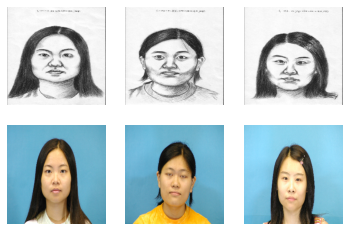

In [30]:
from numpy import load

# load the dataset

data = load('asianstrain_256.npz')
skt_images, real_images = data['arr_0'], data['arr_1']
print('Loaded: ', skt_images.shape, real_images.shape)

# plot source images
n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(skt_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(real_images[i].astype('uint8'))
plt.show()

In [0]:
#discriminator model : PatchGAN

def define_discriminator(image_shape):

    # weight initialization
    init = RandomNormal(stddev=0.02)
 
    # source image input (Sketches)
    in_src_image = Input(shape=image_shape)
 
    # target image input (Real images)
    in_target_image = Input(shape=image_shape)
 
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
 
  #convolutional layers
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
 
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
 
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
 
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
 
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
 
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
 
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 
    return model

In [0]:
# define an encoder block

def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [0]:
# define the standalone generator model

def define_generator(image_shape=(256,256,3)):

    # weight initialization
    init = RandomNormal(stddev=0.02)
 
    # image input
    in_image = Input(shape=image_shape)
 
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
 
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
 
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
 
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
 
    # define model
    model = Model(in_image, out_image)
 
    return model

In [0]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(g_model, d_model, image_shape):

    # make weights in the discriminator not trainable
    d_model.trainable = False

    # define the source image
    in_src = Input(shape=image_shape)
 
    # connect the source image to the generator input
    gen_out = g_model(in_src)
 
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
 
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
 
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
 
    return model

In [0]:
# load and prepare training images

def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
 
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']

    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5

    return [X1, X2]

In [0]:
# select a batch of random samples, returns images and target

def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
  
    X1, X2 = trainA[ix], trainB[ix]

    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
 
    return [X1, X2], y

In [0]:
# generate a batch of images, returns images and targets

def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
 
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
 
    return X, y

In [0]:
# generate samples and save as a plot and save the model

def summarize_performance(step, g_model, gan_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
 
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
 
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
  
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
  
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
  
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
 
    # save the generator model
    filename2 = 'g_model_%06d.h5' % (step+1)
    g_model.save(filename2)
    # print('>Saved: %s and %s' % (filename1, filename2))
 
 # save the model checkpoints after every 10 epochs
    filename3 = 'model_%06d.h5' % (step+1)
    gan_model.save(filename3)
 
    print('>Saved: %s , %s and %s' % (filename1, filename2, filename3))
 

In [0]:
# train pix2pix model

def train(d_model, g_model, gan_model, dataset, n_epochs=300, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    # unpack dataset
    trainA, trainB = dataset

    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
 
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    start_time = time.time()
    print(" Start Time: %.2fs" % start_time)
 
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
  
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
  
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
  
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
  
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
  
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
  
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model,gan_model, dataset)
    print("Time taken: %.2fs" % (time.time() - start_time))

In [48]:
# load image data
dataset = load_real_samples('asianstrain_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>40607, d1[0.000] d2[0.000] g[2.236]
>40608, d1[0.000] d2[0.000] g[2.896]
>40609, d1[0.000] d2[0.000] g[2.495]
>40610, d1[0.000] d2[0.000] g[4.372]
>40611, d1[0.000] d2[0.000] g[3.837]
>40612, d1[0.000] d2[0.000] g[2.799]
>40613, d1[0.000] d2[0.000] g[3.097]
>40614, d1[0.000] d2[0.000] g[2.726]
>40615, d1[0.000] d2[0.000] g[3.076]
>40616, d1[0.000] d2[0.000] g[2.507]
>40617, d1[0.000] d2[0.000] g[2.953]
>40618, d1[0.000] d2[0.000] g[3.034]
>40619, d1[0.000] d2[0.000] g[2.688]
>40620, d1[0.001] d2[0.000] g[2.375]
>40621, d1[0.000] d2[0.000] g[2.772]
>40622, d1[0.000] d2[0.000] g[2.730]
>40623, d1[0.000] d2[0.000] g[2.337]
>40624, d1[0.000] d2[0.001] g[2.769]
>40625, d1[0.000] d2[0.000] g[2.252]
>40626, d1[0.000] d2[0.000] g[2.503]
>40627, d1[0.000] d2[0.000] g[2.858]
>40628, d1[0.000] d2[0.000] g[3.102]
>40629, d1[0.000] d2[0.000] g[2.780]
>40630, d1[0.000] d2[0.000] g[2.705]
>40631, d1[0.000] d2[0.000] g[2.895]
>40632, d1[0.000] d2[0.0

In [0]:
#40.7456 seconds per epoch 
#Total 203.728 minutes = 3.39 hours = 12223.68

[X1, X2] = load_real_samples('./CGAN2/asianstest_256.npz')

model = load_model('./CGAN2/g_model_045600.h5',compile = False)

filename1 = 'test_plot_%06d.png' % (randint(0, 100))
    pyplot.savefig(filename1)
    pyplot.show()